In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [3]:
dataset_choice = "mnist"     
epochs = 60
batch_size = 64
noise_dim = 100
learning_rate = 0.0002
sample_interval = 5          
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [9]:
for epoch in range(1, epochs + 1):
    for imgs, _ in train_loader:

        real_imgs = imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

       
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), real_labels)

        z = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()


    print(
        f"Epoch [{epoch}/{epochs}] "
        f"D_loss: {d_loss.item():.4f} "
        f"G_loss: {g_loss.item():.4f}"
    )

    if epoch % sample_interval == 0:
        z = torch.randn(25, noise_dim).to(device)
        samples = generator(z)
        grid = make_grid(samples, nrow=5, normalize=True)
        save_image(grid, f"generated_samples/epoch_{epoch}.png")

Epoch [1/60] D_loss: 0.7004 G_loss: 3.7324
Epoch [2/60] D_loss: 0.5326 G_loss: 2.9053
Epoch [3/60] D_loss: 1.2331 G_loss: 8.1311
Epoch [4/60] D_loss: 0.3152 G_loss: 2.9801
Epoch [5/60] D_loss: 0.2135 G_loss: 5.1856
Epoch [6/60] D_loss: 0.4943 G_loss: 2.1400
Epoch [7/60] D_loss: 0.4919 G_loss: 1.6716
Epoch [8/60] D_loss: 0.3287 G_loss: 4.7240
Epoch [9/60] D_loss: 0.3991 G_loss: 5.6310
Epoch [10/60] D_loss: 0.3704 G_loss: 2.6351
Epoch [11/60] D_loss: 0.2632 G_loss: 2.8364
Epoch [12/60] D_loss: 0.3188 G_loss: 4.4236
Epoch [13/60] D_loss: 0.0799 G_loss: 5.0519
Epoch [14/60] D_loss: 0.0005 G_loss: 7.7686
Epoch [15/60] D_loss: 0.0001 G_loss: 9.5880
Epoch [16/60] D_loss: 0.2856 G_loss: 66.9035
Epoch [17/60] D_loss: 0.0001 G_loss: 9.4973
Epoch [18/60] D_loss: 0.0001 G_loss: 11.1097
Epoch [19/60] D_loss: 0.0000 G_loss: 11.3008
Epoch [20/60] D_loss: 0.0001 G_loss: 9.5653
Epoch [21/60] D_loss: 0.0016 G_loss: 7.0331
Epoch [22/60] D_loss: 0.0001 G_loss: 9.7998
Epoch [23/60] D_loss: 0.0001 G_loss: 1

In [10]:
z = torch.randn(100, noise_dim).to(device)
final_images = generator(z)

for i in range(100):
    save_image(
        final_images[i],
        f"final_generated_images/image_{i+1}.png",
        normalize=True
    )

print("Training complete. Final images saved.")

Training complete. Final images saved.


In [11]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

classifier = MNISTClassifier().to(device)

In [12]:
optimizer_C = optim.Adam(classifier.parameters(), lr=0.001)
criterion_C = nn.CrossEntropyLoss()

classifier.train()
for epoch in range(3):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_C.zero_grad()
        loss = criterion_C(classifier(imgs), labels)
        loss.backward()
        optimizer_C.step()

In [13]:
import torch.nn.functional as F

# Convert range [-1,1] → [0,1]
gan_images = (final_images + 1) / 2

# 1 channel → 3 channels
gan_images = gan_images.repeat(1, 3, 1, 1)

# Resize 28×28 → 224×224
gan_images = F.interpolate(
    gan_images, size=(224, 224), mode="bilinear", align_corners=False
)

gan_images = gan_images.to(device)

In [14]:
classifier = classifier.to(device)
classifier.eval()

for p in classifier.parameters():
    p.requires_grad = False

In [15]:
gan_images = gan_images.to(device)

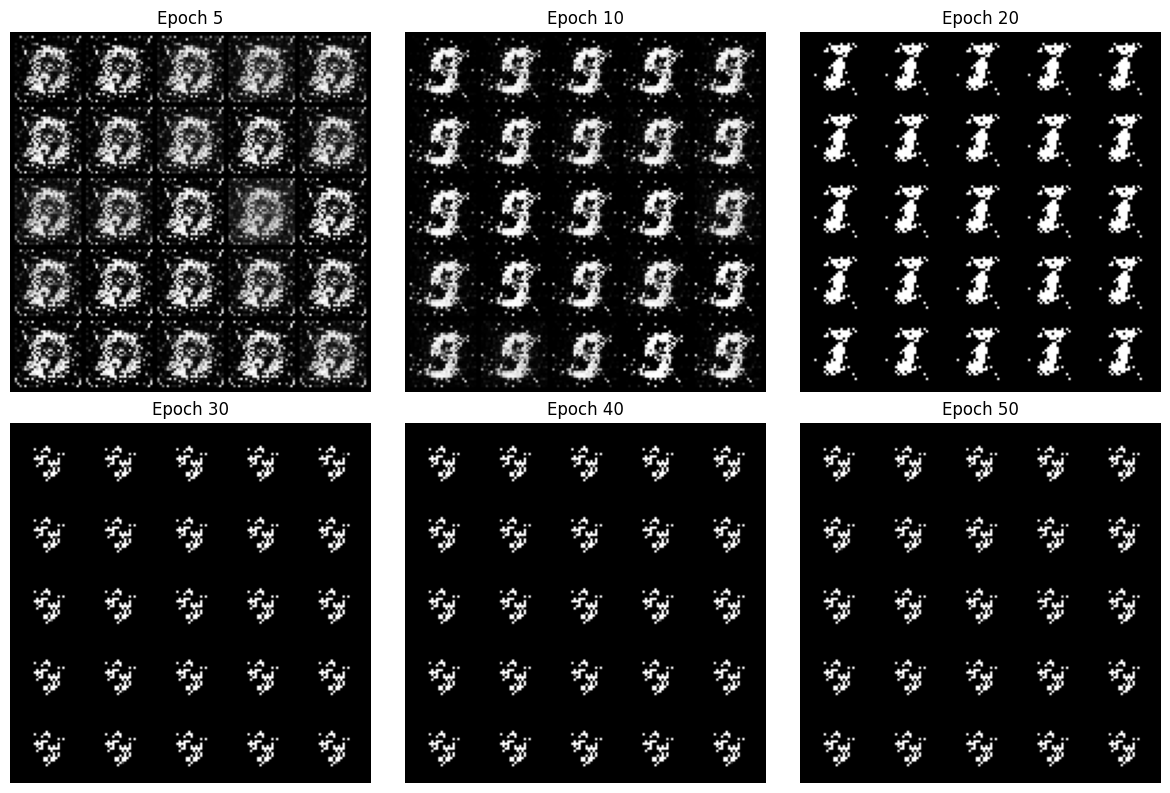

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

epochs = [5, 10, 20, 30, 40, 50]

plt.figure(figsize=(12, 8))

for i, ep in enumerate(epochs):
    img = Image.open(f"generated_samples/epoch_{ep}.png")
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Epoch {ep}")

plt.tight_layout()
plt.show()